# Model Analysis

In [2]:
import numpy as np
import glob
import warnings
from pathlib import Path
from gensim.models.word2vec import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TODO: Fix interactive plot
# Get the interactive Tools for Matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

In [3]:
warnings.filterwarnings("ignore")

model_dir = Path("model/")
model_files = glob.glob(str(model_dir / "*.model"))

In [4]:
# Get models by their split date
model_files_griner = [model_file for model_file in model_files if "07_Oct" in model_file]
model_files_twitter = [model_file for model_file in model_files if "01_Oct" in model_file]
model_files_pelosi = [model_file for model_file in model_files if "26_Oct" in model_file]
model_files_colorado_springs = [model_file for model_file in model_files if "18_Nov" in model_file]

'''
model_files_fifa = [model_file for model_file in model_files if "01_Nov" in model_file]
model_files_seoul = [model_file for model_file in model_files if "28_Oct" in model_file] ''';

In [5]:
model_files_griner

['model/01_Jun_to_07_Oct.model', 'model/07_Oct_to_28_Apr.model']

In [6]:
model_files_twitter

['model/01_Oct_to_28_Apr.model', 'model/01_Jun_to_01_Oct.model']

In [7]:
model_files_pelosi

['model/26_Oct_to_28_Apr.model', 'model/01_Jun_to_26_Oct.model']

In [8]:
model_files_colorado_springs

['model/01_Jun_to_18_Nov.model', 'model/18_Nov_to_28_Apr.model']

In [9]:
model_griner_pre = Word2Vec.load(model_files_griner[0])
model_griner_post = Word2Vec.load(model_files_griner[1])

model_twitter_pre = Word2Vec.load(model_files_twitter[1])
model_twitter_post = Word2Vec.load(model_files_twitter[0])

model_pelosi_pre = Word2Vec.load(model_files_pelosi[1])
model_pelosi_post = Word2Vec.load(model_files_pelosi[0])

model_colorado_springs_pre = Word2Vec.load(model_files_colorado_springs[0])
model_colorado_springs_post = Word2Vec.load(model_files_colorado_springs[1])

model_static = Word2Vec.load("model/word2vec.model")

# 2-D Visualization

Simple 2D visualization of word-embeddings.
The function uses PCA for dimensionality reduction.
source: [stanford.web](https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html)
(Source-Code has been slightly modified)

In [288]:
def display_scatterplot(model, keyword, words, title = "Words in the embedding space", subtitle = None, use_tsne=False, ):

    # Iff use_tsne is True, perform t-SNE, otherwise perform PCA
    if use_tsne:
        vectors_2d = perform_tsne(model, words)
    else:
        vectors_2d = perform_pca(model, words)

    # Create a scatter plot
    plt.figure(figsize=(6,6))
    plt.scatter(vectors_2d[:,0], vectors_2d[:,1], edgecolors='k', c='orange')

    # Add word labels to the scatter plot
    for word, (x,y) in zip(words, vectors_2d):
        color = 'red' if word == keyword else 'orange'
        plt.text(x + 0.05, y + 0.05, word, color=color)

    # Set plot titles
    plt.suptitle(title, fontsize=14)
    plt.title(subtitle, fontsize=10)

In [150]:
def perform_pca(model, words):

    # Convert the word vectors of the specified words into a NumPy array
    word_vectors = np.array([model[w] for w in words])

    # 1. Apply PCA to reduce dimensionality to 2 components
    # 2. Perform the PCA transformation on the word vectors and select the first 2 dimensions
    return PCA().fit_transform(word_vectors)[:, :2]

In [250]:
from sklearn.preprocessing import StandardScaler
def perform_tsne(model, words):

    # Convert the word vectors of the specified words into a NumPy array
    word_vectors = np.array([model[w] for w in words])


    # 1. Apply t-SNE with 2 components, using perplexity adjusted based on the number of words
    # 2. Perform the t-SNE transformation on the word vectors
    transformed_word_vectors = TSNE(n_components=2, perplexity=len(word_vectors) / 2, random_state=1040).fit_transform(word_vectors)
    # Fit the scaler on t-SNE vectors
    scaler = StandardScaler()
    normalized_tsne_vectors = scaler.fit_transform(transformed_word_vectors)

    return normalized_tsne_vectors

In [234]:
vis_list_pelosi = ["hammer", "nail", "carpent", "pelosi", "nanci"]
word_vectors = np.array([model_static.wv[w] for w in vis_list_pelosi])

In [235]:
word_vectors[:,:2]

array([[-0.1071309 ,  0.3740296 ],
       [-0.10111532, -0.51417834],
       [-0.04911763,  0.2993966 ],
       [-1.225141  ,  0.12352458],
       [-1.2224202 ,  0.2730416 ]], dtype=float32)

In [236]:
vectors_2d = perform_tsne(model_static.wv, vis_list_pelosi)
vectors_2d

array([[-0.00159133,  0.52615726],
       [ 1.3290817 ,  1.0755993 ],
       [-1.385971  ,  0.80980265],
       [-0.7803628 , -1.2422165 ],
       [ 0.8388433 , -1.1693428 ]], dtype=float32)

In [237]:
vectors_2d_pca = perform_pca(model_static.wv, vis_list_pelosi)
vectors_2d_pca

array([[-1.055848  , -0.73285425],
       [-2.413718  ,  2.2520983 ],
       [-2.0829976 , -1.8513969 ],
       [ 3.1841364 ,  0.02330343],
       [ 2.3684263 ,  0.30885   ]], dtype=float32)

## Release of Brittney Griner

On December 8, 2022, Russia and the United States conducted a prisoner exchange, trading Brittney Griner, an American basketball player, for Viktor Bout, a Russian arms dealer. Griner, a WNBA champion star and Team USA Olympic athlete, had been convicted of smuggling and possession of cannabis in Russia earlier in 2022 and sentenced to nine years in prison.

Source: [Wikipedia article](https://en.wikipedia.org/wiki/Viktor_Bout%E2%80%93Brittney_Griner_prisoner_exchange)

In [238]:
test_word_griner = "griner"

01.06.2022 - 07.10.2022

In [239]:
model_griner_pre.wv.most_similar(test_word_griner)

[('brittney', 0.9787509441375732),
 ('holliday', 0.9750015139579773),
 ('337', 0.9724785089492798),
 ('ksat', 0.9709987044334412),
 ('duggar', 0.9709590077400208),
 ('32yearold', 0.9705320596694946),
 ('robinett', 0.9701023101806641),
 ('rena', 0.969632089138031),
 ('crosbi', 0.9691656827926636),
 ('granger', 0.9690356254577637)]

07.10.2022 - 28.04.2023

In [240]:
model_griner_post.wv.most_similar(test_word_griner)

[('iraq', 0.910420298576355),
 ('zelenskyy', 0.8817284107208252),
 ('belarus', 0.8690013289451599),
 ('freed', 0.8613867163658142),
 ('syria', 0.8594682216644287),
 ('viktor', 0.8564624190330505),
 ('tatarski', 0.8543269634246826),
 ('bomber', 0.8516713976860046),
 ('kherson', 0.8503154516220093),
 ('kremlin', 0.8467178344726562)]

In [241]:
vis_list_griner = ["brittney", "holliday", "32yearold", "griner", "russia", "iraq", "freed"]
title_griner = "Brittney Griner prisoner exchange"

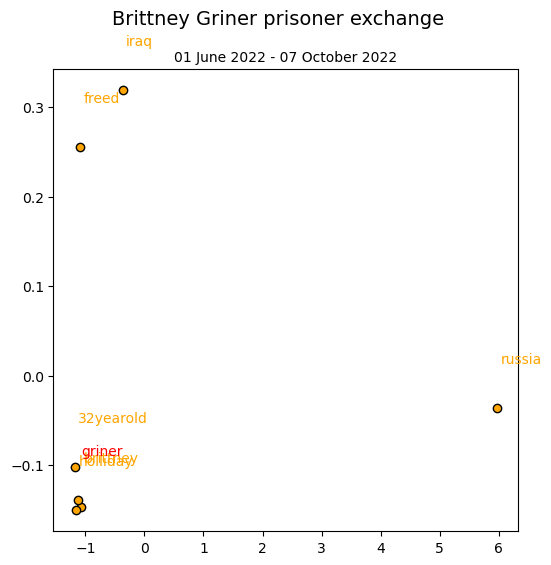

In [289]:
display_scatterplot(model_griner_pre.wv, test_word_griner, vis_list_griner, title=title_griner, subtitle="01 June 2022 - 07 October 2022")

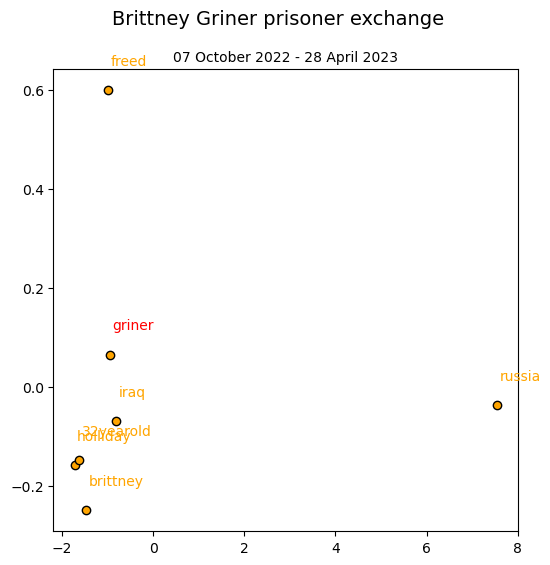

In [290]:
display_scatterplot(model_griner_post.wv, test_word_griner, vis_list_griner, title=title_griner, subtitle="07 October 2022 - 28 April 2023")

## Elon Musk Twitter takeover

Business magnate Elon Musk initiated an acquisition of American social media company Twitter, Inc. on April 14, 2022, and concluded it on October 27, 2022. Musk had begun buying shares of the company in January 2022, becoming its largest shareholder by April with a 9.1 percent ownership stake

source: [Wikipedia article](https://en.wikipedia.org/wiki/Acquisition_of_Twitter_by_Elon_Musk#:~:text=Business%20magnate%20Elon%20Musk%20initiated,a%209.1%20percent%20ownership%20stake.)

In [291]:
test_word_twitter = "twitter"

In [309]:
model_twitter_pre.wv.most_similar(test_word_twitter)

[('tweet', 0.8812525272369385),
 ('reed', 0.8721252679824829),
 ('user', 0.8314453363418579),
 ('instagram', 0.8219107985496521),
 ('facebook', 0.8200446367263794),
 ('tiktok', 0.8032370209693909),
 ('jojo', 0.7980067729949951),
 ('text', 0.7537107467651367),
 ('steph', 0.7404765486717224),
 ('lib', 0.733768880367279)]

In [310]:
model_twitter_post.wv.most_similar(test_word_twitter)

[('musk', 0.8743116855621338),
 ('elon', 0.8227738738059998),
 ('tweet', 0.8056724667549133),
 ('repost', 0.7935503125190735),
 ('facebook', 0.7915476560592651),
 ('roth', 0.7494595050811768),
 ('screenshot', 0.7241086959838867),
 ('sms', 0.7018388509750366),
 ('hashtag', 0.699127197265625),
 ('meme', 0.6930449604988098)]

In [311]:
vis_list_twitter = ["facebook", "instagram", "tiktok", "user", "twitter", "elon", "musk", "tesla"]
title_twitter = "Acquisition of Twitter by Elon Musk"

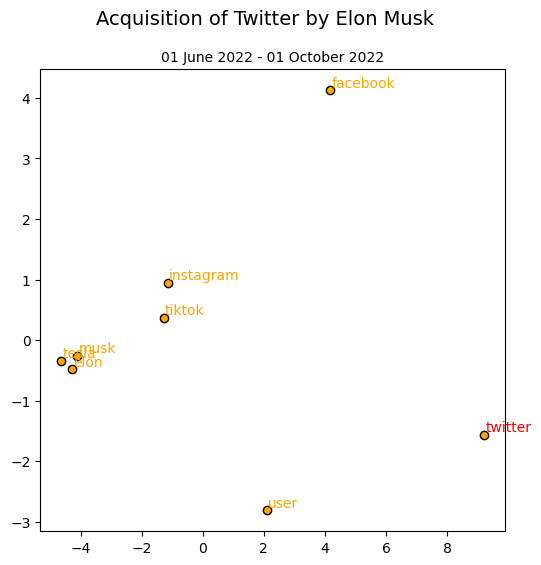

In [312]:
display_scatterplot(model_twitter_pre.wv, test_word_twitter, vis_list_twitter, title_twitter, "01 June 2022 - 01 October 2022")

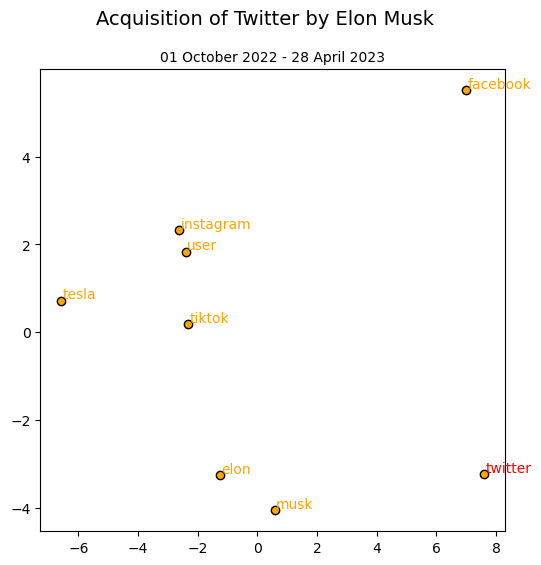

In [313]:
display_scatterplot(model_twitter_post.wv, test_word_twitter, vis_list_twitter, title_twitter, "01 October 2022 - 28 April 2023")

## Attack on Paul Pelosi

On October 28, 2022, an intruder attacked Paul Pelosi, the 82-year-old husband of Nancy Pelosi, then the Speaker of the United States House of Representatives. The assailant beat Paul Pelosi with a hammer during a home invasion burglary of the couple's residence in Pacific Heights, San Francisco. He was seriously injured and underwent surgery for his fractured skull.

source: [Wikipedia article](https://en.wikipedia.org/wiki/Attack_on_Paul_Pelosi)

In [314]:
test_word_pelosi = "hammer"

In [315]:
model_pelosi_pre.wv.most_similar(test_word_pelosi)

[('bruis', 0.7742449641227722),
 ('sununu', 0.7518554329872131),
 ('tudor', 0.7489067316055298),
 ('governorship', 0.7480438351631165),
 ('walz', 0.7436500191688538),
 ('trumpback', 0.73427814245224),
 ('fullon', 0.7255422472953796),
 ('rainmak', 0.7234987616539001),
 ('busto', 0.7222893834114075),
 ('landslid', 0.7194502949714661)]

In [316]:
model_pelosi_post.wv.most_similar(test_word_pelosi)

[('pelosi', 0.8169354200363159),
 ('nanci', 0.8076074719429016),
 ('stomp', 0.7625229954719543),
 ('antihateca', 0.7621437907218933),
 ('skeleton', 0.7454701066017151),
 ('beat', 0.7218031883239746),
 ('whip', 0.7213331460952759),
 ('cheer', 0.7169202566146851),
 ('trio', 0.7141595482826233),
 ('flame', 0.7045955061912537)]

In [317]:
vis_list_pelosi = ["hammer", "nail", "carpent", "pelosi", "nanci"]
title_pelosi = "Attack on Paul Pelosi"

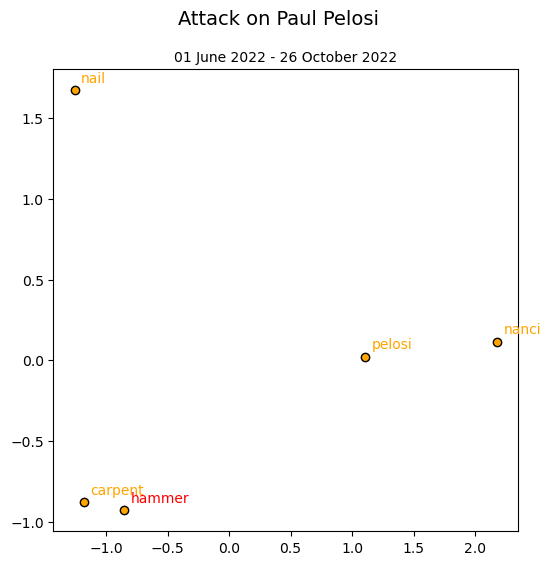

In [318]:
display_scatterplot(model_pelosi_pre.wv, test_word_pelosi, vis_list_pelosi, title_pelosi, "01 June 2022 - 26 October 2022")

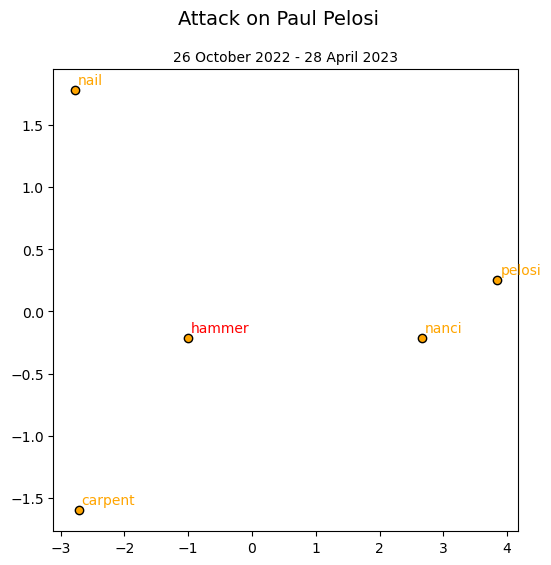

In [319]:
display_scatterplot(model_pelosi_post.wv, test_word_pelosi, vis_list_pelosi, title_pelosi, "26 October 2022 - 28 April 2023")

## Colorado Springs shooting at LGBTQ nightclub

On November 19–20, 2022, an anti-LGBT-motivated mass shooting occurred at Club Q, a gay bar in Colorado Springs, Colorado, United States. Five people were murdered, and 25 others were injured, 19 of them by gunfire. The shooter, 22-year-old Anderson Lee Aldrich, was also injured while being restrained, and was taken to a local hospital

source: [wikipedia article](https://en.wikipedia.org/wiki/Colorado_Springs_nightclub_shooting)

In [320]:
test_word_colorado_springs = "nightclub"

In [321]:
model_colorado_springs_pre.wv.most_similar(test_word_colorado_springs)

[('shanghai', 0.753409743309021),
 ('mainland', 0.7484889626502991),
 ('firework', 0.7330538034439087),
 ('hainan', 0.7279052734375),
 ('xian', 0.7240670323371887),
 ('beij', 0.7202854156494141),
 ('guangzhou', 0.7188722491264343),
 ('colloquium', 0.7168283462524414),
 ('covidposit', 0.7125265002250671),
 ('songpinganq', 0.7116169333457947)]

In [322]:
model_colorado_springs_post.wv.most_similar(test_word_colorado_springs)

[('gunman', 0.7976378798484802),
 ('colorado', 0.7775311470031738),
 ('deadliest', 0.7731342315673828),
 ('rampag', 0.7722783088684082),
 ('nashvill', 0.7657735347747803),
 ('shipbuild', 0.7507109045982361),
 ('spree', 0.7496422529220581),
 ('polytechniqu', 0.7486120462417603),
 ('thepostmillennialcomtransmalearr', 0.7485789656639099),
 ('cosantifascistscosantifa', 0.743838369846344)]

In [329]:
vis_list_colorado_springs = ["drink", "mainland", "firework", "nightclub", "massacr", "gunman"]
title_colorado_springs = "Colorado Springs nightclub shooting"

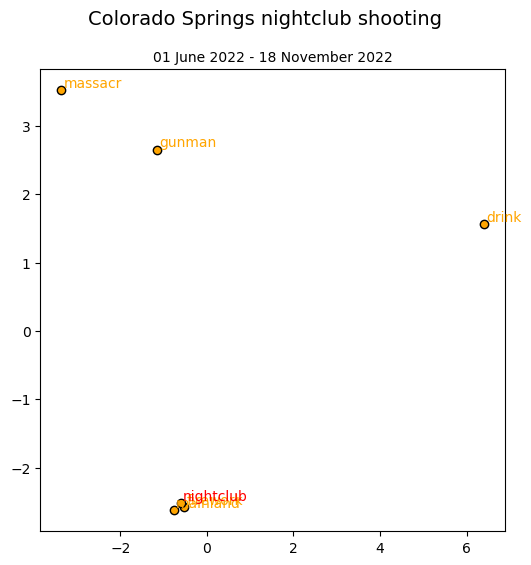

In [330]:
display_scatterplot(model_colorado_springs_pre.wv, test_word_colorado_springs, vis_list_colorado_springs, title_colorado_springs, "01 June 2022 - 18 November 2022")

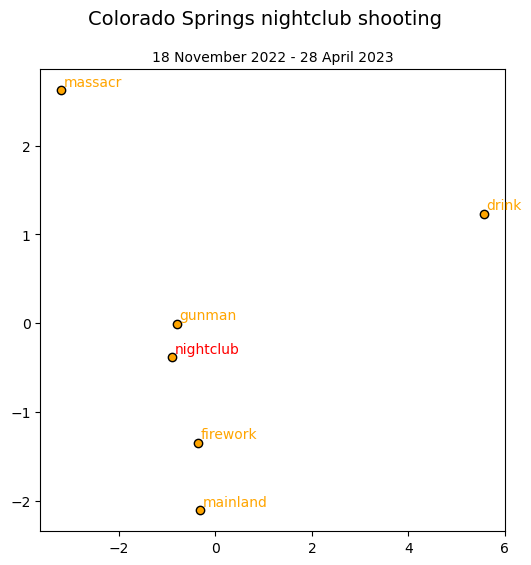

In [331]:
display_scatterplot(model_colorado_springs_post.wv, test_word_colorado_springs, vis_list_colorado_springs, title_colorado_springs, "18 November 2022 - 28 April 2023")